In [1]:
# %tensorflow_version 2.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import skimage

In [2]:
import tensorflow_datasets as tfds
merced_builder = tfds.builder('uc_merced')
# Download the dataset
merced_builder.download_and_prepare()

Shuffling and writing examples to /home/jonathan/tensorflow_datasets/uc_merced/2.0.0.incomplete55W5LA/uc_merced-train.tfrecord


Dataset uc_merced downloaded and prepared to /home/jonathan/tensorflow_datasets/uc_merced/2.0.0. Subsequent calls will reuse this data.


In [3]:
print(merced_builder.info)


tfds.core.DatasetInfo(
    name='uc_merced',
    version=2.0.0,
    description='UC Merced is a 21 class land use remote sensing image dataset, with 100 images
per class. The images were manually extracted from large images from the USGS
National Map Urban Area Imagery collection for various urban areas around the
country. The pixel resolution of this public domain imagery is 0.3 m.

While most images are 256x256 pixels, there are 44 images with different shape.',
    homepage='http://weegee.vision.ucmerced.edu/datasets/landuse.html',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=21),
    }),
    total_num_examples=2100,
    splits={
        'train': 2100,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{Nilsback08,
       author = "Yang, Yi and Newsam, Shawn",
       title = "Bag-Of-Visual-Words

In [4]:
f = merced_builder.info.features['image']
print(f)


Image(shape=(None, None, 3), dtype=tf.uint8)


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


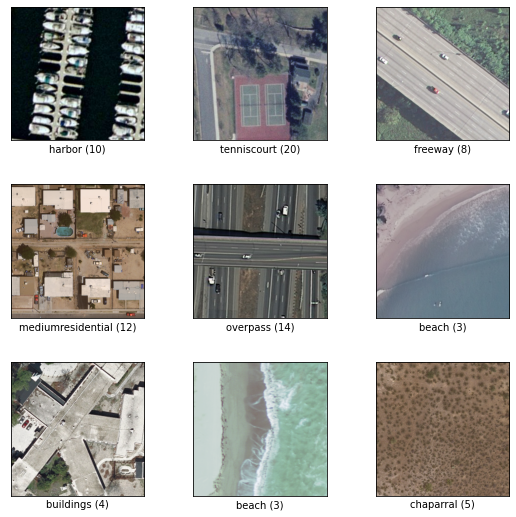

In [5]:
# get the data as a tensorflow dataset
datasets = merced_builder.as_dataset()
full_ds = datasets['train']
fig = tfds.show_examples(merced_builder.info, full_ds)

In [6]:
# add gaussian noise to image
# note: this returns the noisy image as well as the original image
def add_noise(original, std_dev=0.1):
    noise = tf.random.normal(shape=tf.shape(original), mean=0.0, stddev=std_dev, dtype=tf.float32)
    noisy = tf.add(original, noise)
    noisy = tf.clip_by_value(noisy, 0.0, 1.0) # adding noise might make values > 1.0
    # return both the noisy and the normal image
    tensor_tuple = (noisy, original)
    return tensor_tuple

In [7]:
PATCH_WIDTH = 128
PATCH_HEIGHT = 128
# extracts patches of given size from the image
def extract_patches(example, patch_width=PATCH_HEIGHT, patch_height=PATCH_HEIGHT):
  img = example['image']
  img = tf.image.convert_image_dtype(img, tf.float32)
  patches = tf.image.extract_patches([img], 
     sizes=[1, patch_height, patch_width, 1], 
     strides=[1, patch_height, patch_width, 1],
     rates=[1, 1, 1, 1],
     padding='SAME')
  img_tensor = tf.reshape(patches, [-1, patch_height, patch_width, 3])
  return tf.data.Dataset.from_tensor_slices(img_tensor)

In [8]:
TRAIN_SIZE = int(2100*0.7)

train_ds = full_ds.take(TRAIN_SIZE)
test_ds = full_ds.skip(TRAIN_SIZE)

In [9]:
# prep dataset for training
train_ds = train_ds.flat_map(extract_patches)
train_ds = train_ds.map(add_noise)

In [10]:
# prep dataset for testing
# full-size patches in test data, want to test whole images
test_ds = test_ds.flat_map(lambda x: extract_patches(x, 256, 256))
test_ds = test_ds.map(add_noise)
test_ds = test_ds.batch(1) # one item per batch

In [11]:
print(test_ds)

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>


In [12]:
some_patches = train_ds.take(5)
print(some_patches)

<TakeDataset shapes: ((128, 128, 3), (128, 128, 3)), types: (tf.float32, tf.float32)>


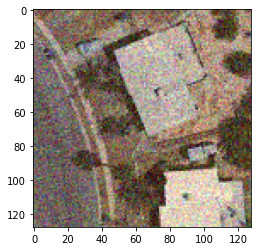

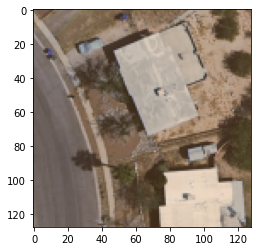

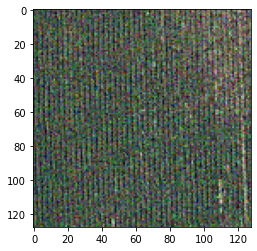

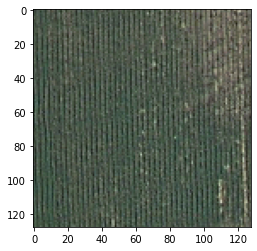

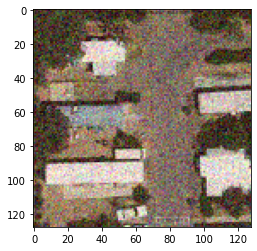

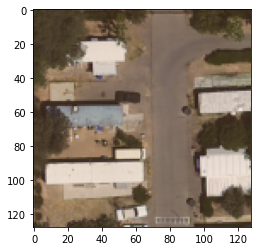

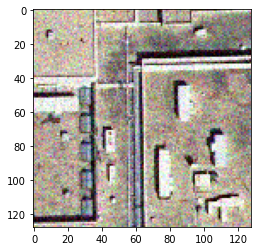

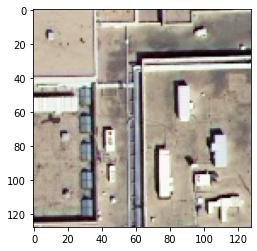

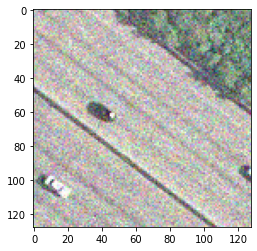

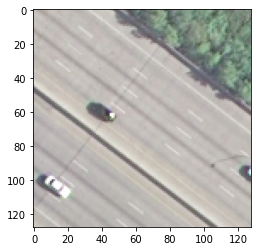

In [13]:
for noisy, orig in train_ds.shuffle(100).take(5): #shuffling before 'take' will give us different images each time
    plt.figure()
    plt.imshow(noisy)
    plt.figure()
    plt.imshow(orig)

In [14]:
# repeat, shuffle and batch
train_ds = train_ds.repeat().shuffle(1024).batch(32)
# prefetch to asynchronously fetch batches while the model is training
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)